In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive, files

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path ke dataset di Google Drive
train_dir = '/content/drive/MyDrive/dataset/training'
valid_dir = '/content/drive/MyDrive/dataset/validation'
test_dir = '/content/drive/MyDrive/dataset/test'  # Path ke dataset testing

In [ ]:
# ImageDataGenerator untuk augmentasi dan preprocessing data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2
)

In [ ]:
# ImageDataGenerator untuk data validation
valid_datagen = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
# Load dan preprocess training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 4215 images belonging to 3 classes.


In [ ]:
# Load dan preprocess validation data
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 465 images belonging to 3 classes.


In [ ]:
# ImageDataGenerator untuk data testing
test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
# Load dan preprocess test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 6 images belonging to 3 classes.


In [ ]:
# Load model ResNet50 tanpa top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Tambahkan custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Menambahkan dropout untuk regularisasi
predictions = Dense(3, activation='softmax')(x)  # 3 classes: crack, pothole, good

In [ ]:
# Buat model final
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Freeze sebagian besar layers dari base model, kecuali beberapa layer terakhir
for layer in base_model.layers[:143]:
    layer.trainable = False
for layer in base_model.layers[143:]:
    layer.trainable = True

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

In [ ]:
# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20,  # Ganti dengan jumlah epoch yang Anda inginkan
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/20
131/131 [==============================] - 142s 1s/step - loss: 0.6335 - accuracy: 0.7234 - val_loss: 1.1840 - val_accuracy: 0.3482 - lr: 1.0000e-04
Epoch 2/20
131/131 [==============================] - 127s 969ms/step - loss: 0.5114 - accuracy: 0.7985 - val_loss: 0.8013 - val_accuracy: 0.6853 - lr: 1.0000e-04
Epoch 3/20
131/131 [==============================] - 130s 992ms/step - loss: 0.4589 - accuracy: 0.8224 - val_loss: 3.0646 - val_accuracy: 0.3996 - lr: 1.0000e-04
Epoch 4/20
131/131 [==============================] - 131s 999ms/step - loss: 0.4276 - accuracy: 0.8415 - val_loss: 0.6097 - val_accuracy: 0.7589 - lr: 1.0000e-04
Epoch 5/20
131/131 [==============================] - 130s 995ms/step - loss: 0.4058 - accuracy: 0.8432 - val_loss: 0.4961 - val_accuracy: 0.8013 - lr: 1.0000e-04
Epoch 6/20
131/131 [==============================] - 128s 977ms/step - loss: 0.3936 - accuracy: 0.8484 - val_loss: 0.7099 - val_accuracy: 0.6987 - lr: 1.0000e-04
Epoch 7/20
131/131 [=====

In [ ]:
# Save the trained model in .keras format
model.save('/content/drive/MyDrive/dataset/savemodel/roadcrack.keras')

In [ ]:
# Model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

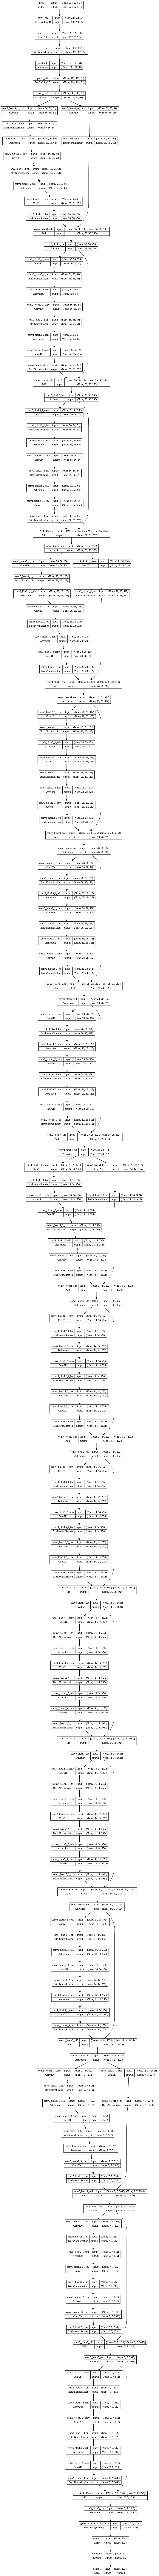

In [ ]:
# Plot model architecture
plot_model(model, to_file='/content/drive/MyDrive/dataset/savemodel/model_architecture.png', show_shapes=True, show_layer_names=True)

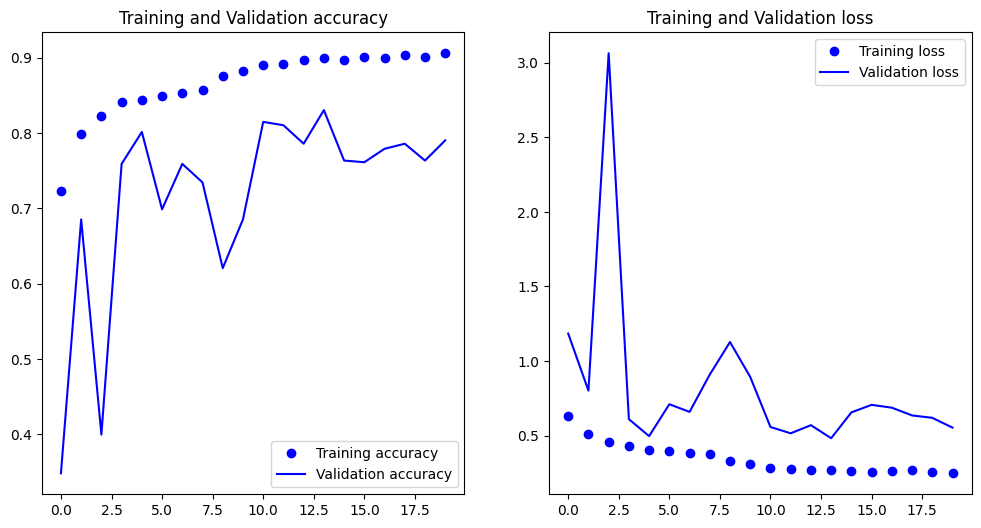

In [102]:
# Plot Training & Validation Accuracy and Loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

# Call the function to plot training history
plot_training_history(history)

1/1 [==============================] - 2s 2s/step


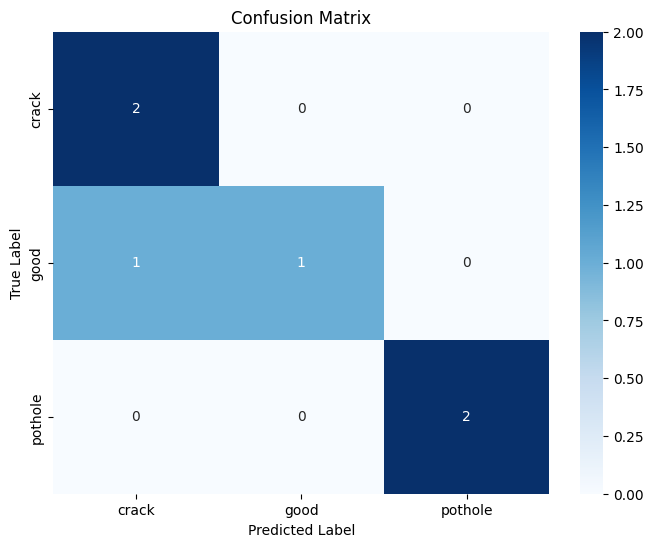

Classification Report
              precision    recall  f1-score   support

       crack       0.67      1.00      0.80         2
        good       1.00      0.50      0.67         2
     pothole       1.00      1.00      1.00         2

    accuracy                           0.83         6
   macro avg       0.89      0.83      0.82         6
weighted avg       0.89      0.83      0.82         6



In [103]:
# Predict the values from the test dataset
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print('Classification Report')
print(classification_report(true_classes, y_pred, target_names=class_labels))